In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Tạo mô hình SmallAlexNet

In [2]:
class SmallAlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SmallAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Tầng tích chập đầu tiên
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Giảm kích thước ảnh

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Tầng tích chập thứ hai
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Tiếp tục giảm kích thước ảnh
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),  # Fully connected layer đầu tiên
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),  # Fully connected layer cuối cùng
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# 2. Chuẩn bị dữ liệu

In [3]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 26421880/26421880 [00:21<00:00, 1252752.32it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 136369.06it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1193403.14it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6202894.86it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# 3. Khởi tạo mô hình, loss function và optimizer

In [4]:
model = SmallAlexNet(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# 4. Huấn luyện mô hình

In [5]:
num_epochs = 5
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()
    for i, (inputs, labels) in enumerate(trainloader):
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(100 * correct / total)

    # Đánh giá trên tập test
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(testloader))
    test_accuracies.append(100 * correct / total)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Test Acc: {test_accuracies[-1]:.2f}%')

Epoch [1/5], Train Loss: 0.4505, Test Loss: 0.3494, Train Acc: 83.79%, Test Acc: 87.58%
Epoch [2/5], Train Loss: 0.2888, Test Loss: 0.3058, Train Acc: 89.55%, Test Acc: 88.85%
Epoch [3/5], Train Loss: 0.2403, Test Loss: 0.2907, Train Acc: 91.25%, Test Acc: 89.86%
Epoch [4/5], Train Loss: 0.2068, Test Loss: 0.2577, Train Acc: 92.30%, Test Acc: 90.81%
Epoch [5/5], Train Loss: 0.1792, Test Loss: 0.2368, Train Acc: 93.32%, Test Acc: 91.92%


# 5. Vẽ biểu đồ đánh giá mô hình

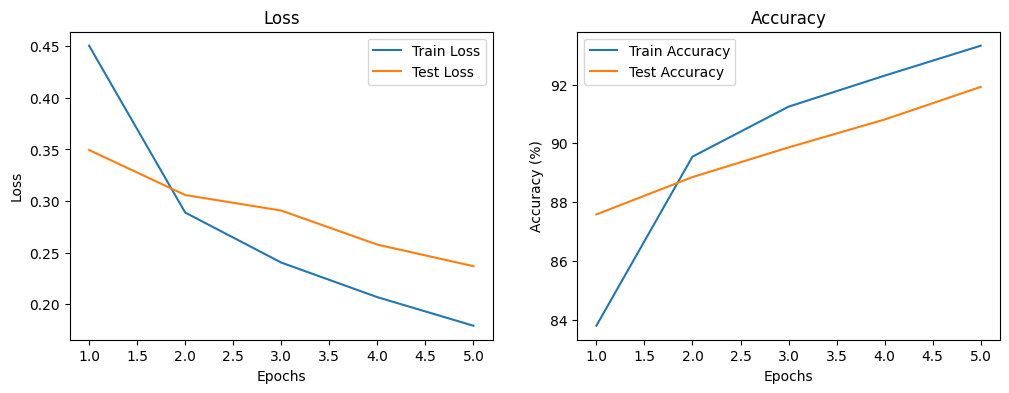

In [6]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# 6. Dự đoán với một ảnh cụ thể

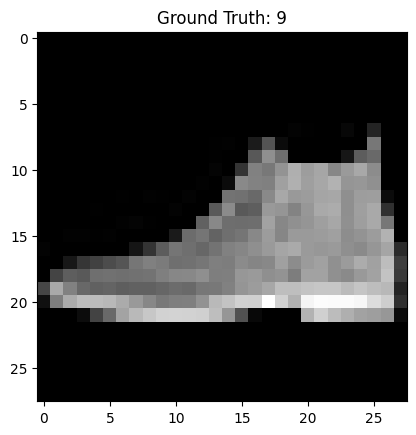

Predicted Label: 9


In [8]:
def predict_single_image(model, image):
    model.eval()
    with torch.no_grad():
        output = model(image.unsqueeze(0))
        _, predicted = torch.max(output, 1)
    return predicted.item()

# Lấy một ảnh từ tập test
image, label = testset[0]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'Ground Truth: {label}')
plt.show()

# Chạy dự đoán với ảnh đó
predicted_label = predict_single_image(model, image)
print(f'Predicted Label: {predicted_label}')